# Import Resources

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
from sshtunnel import SSHTunnelForwarder
import pandas as pd
import pymysql
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


# READ Data

In [2]:
DATA_PATH = 'D:\Github\Infrared-Solar-Modules-Classifier\Data/2020-02-14_InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [3]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
# Read the JSON file located at 'METADATA_PATH' into a DataFrame
# The 'orient' parameter is set to 'index' to indicate that the JSON file is in a dictionary-like format
# Sort the DataFrame by its index (row labels) in ascending order

df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
# Apply a lambda function to the 'image_filepath' column of the DataFrame
# The lambda function uses 'os.path.join' to concatenate 'DATA_PATH' with each value in the 'image_filepath' column

df
# Return the modified DataFrame

,image_filepath,anomaly_class
0,D:\Github\Infrared-Solar-Modules-Classifier\Da...,Offline-Module
1,D:\Github\Infrared-Solar-Modules-Classifier\Da...,Offline-Module
2,D:\Github\Infrared-Solar-Modules-Classifier\Da...,Offline-Module
3,D:\Github\Infrared-Solar-Modules-Classifier\Da...,Offline-Module
4,D:\Github\Infrared-Solar-Modules-Classifier\Da...,Offline-Module
...,...,...
19995,D:\Github\Infrared-Solar-Modules-Classifier\Da...,No-Anomaly
19996,D:\Github\Infrared-Solar-Modules-Classifier\Da...,No-Anomaly
19997,D:\Github\Infrared-Solar-Modules-Classifier\Da...,No-Anomaly
19998,D:\Github\Infrared-Solar-Modules-Classifier\Da...,No-Anomaly


There's a class imbalance in the data.
But only between anomalies.

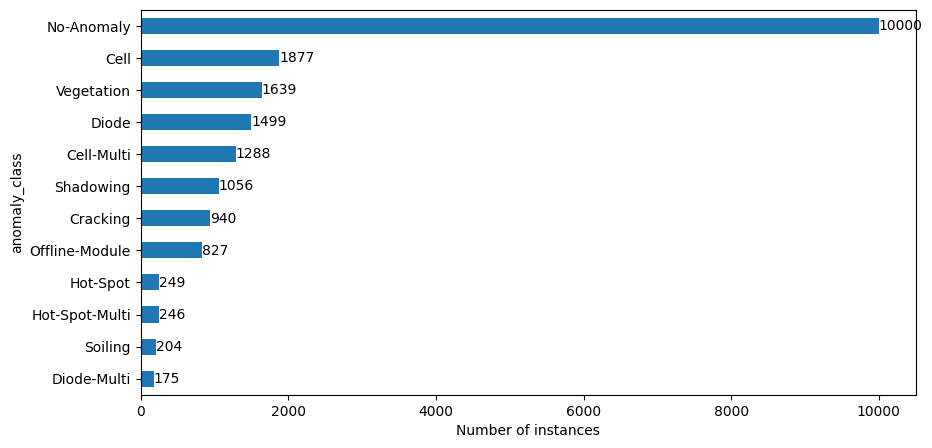

In [4]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
# Count the occurrences of each value in the 'anomaly_class' column of the DataFrame
# Sort the counts in ascending order
# Create a horizontal bar plot with the sorted counts
# The resulting plot is stored in the 'ax' variable

ax.bar_label(ax.containers[0])
# Add labels to the bars of the bar plot using the counts from the first container in the plot

ax.set_xlabel('Number of instances')
# Set the x-axis label of the plot to 'Number of instances'

plt.show()
# Display the plot

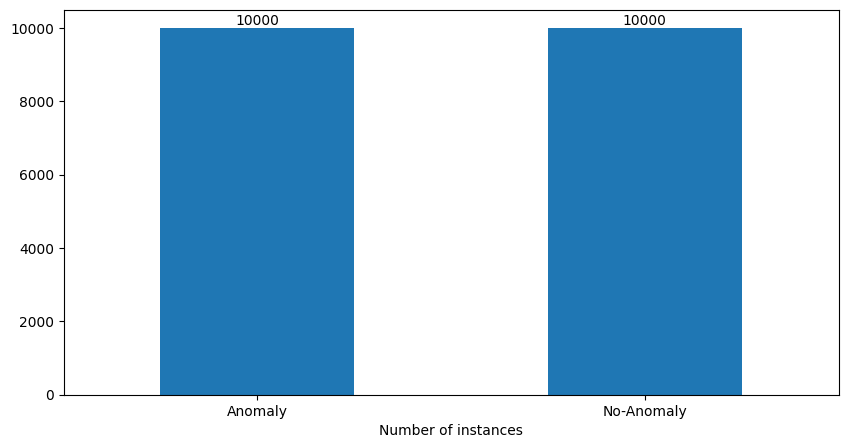

In [5]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x
# This function takes a value 'x' and converts it to 'Anomaly' if it is not equal to 'No-Anomaly', otherwise it remains unchanged

ax = df.anomaly_class.apply(convert_to_binary).value_counts().plot.bar(figsize=(10,5))
# Apply the 'convert_to_binary' function to the 'anomaly_class' column of the DataFrame,
# count the occurrences of each value, and create a bar plot with the resulting counts
# The resulting plot is stored in the 'ax' variable

ax.tick_params(labelrotation=0)
# Set the rotation of the x-axis labels to 0 degrees

ax.bar_label(ax.containers[0])
# Add labels to the bars of the bar plot using the counts from the first container in the plot

ax.set_xlabel('Number of instances')
# Set the x-axis label of the plot to 'Number of instances'

plt.show()
# Display the plot

In [6]:
df.columns

Index(['image_filepath', 'anomaly_class'], dtype='object')

# **DATA BASE**

In [7]:
## VARIABLE DEFINITIONS

ssh_ip_address = ''
ssh_p_username = ''
ssh_p_password = ""
ssh_port = 22
ssh_remote_bind_address = 3306
db_server_ip = ''
db_server_port = 3306
db_user = ''
db_user_password = ''
db_name = ''


## SSH CONNECTION

tunnel = SSHTunnelForwarder((ssh_ip_address, 22), ssh_password=ssh_p_password, ssh_username=ssh_p_username,
                            remote_bind_address=('127.0.0.1', 3306))
tunnel.start()
# Establish an SSH tunnel to the remote server using the specified IP address, port, username, and password
# The tunnel will bind to the local address '127.0.0.1' and port 3306

# MYSQL CONNECTION
db = pymysql.connect(host='localhost', port=tunnel.local_bind_port, user=ssh_p_username,
                          passwd=db_user_password, db=db_name)
# Establish a connection to the MySQL server using the local bind port of the SSH tunnel, username, password, and database name




# # Created a table called Thermal_Images_PV with 3 colums: Name, Label and Feature1
# cur = db.cursor()
# create_table_query = '''
#     CREATE TABLE TI_PV_main (
#         id INT PRIMARY KEY AUTO_INCREMENT,
#         Name VARCHAR(255),
#         Label VARCHAR(255),
#         Feature1 DECIMAL(17, 15)
#     );
# '''
# cur.execute(create_table_query)
# cur.close()



Cursor

In [8]:
db = pymysql.connect(host='localhost', port=tunnel.local_bind_port, user=ssh_p_username,
                          passwd=db_user_password, db=db_name)
# Establish a connection to the database using the specified host, port, username, password, and database name

cur = db.cursor()
# Create a cursor object to execute SQL queries on the database

Read column name

In [9]:
cur.execute("SELECT * FROM TI_PV_main LIMIT 1")
# Execute the SQL query to select the first row from the TI_PV_main table

column_names = [column[0] for column in cur.description]
# Extract the column names from the description of the query result
# The description contains metadata about the columns in the result set

print(column_names)
# Print the list of column names

['id', 'Label', 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10', 'Feature11', 'Feature12', 'Feature13', 'Feature14', 'Feature15', 'Feature16', 'Feature17', 'Feature18', 'Feature19', 'Feature20', 'Feature21', 'Feature22', 'Feature23', 'Feature24', 'Feature25', 'Feature26', 'Feature27', 'Feature28', 'Feature29', 'Feature30', 'Feature31', 'Feature32', 'Feature33', 'Feature34', 'Feature35', 'Feature36', 'Feature37', 'Feature38', 'Feature39', 'Feature40', 'Feature41', 'Feature42', 'Feature43', 'Feature44', 'Feature45', 'Feature46', 'Feature47', 'Feature48', 'Feature49', 'Feature50', 'Feature51', 'Feature52', 'Feature53', 'Feature54', 'Feature55', 'Feature56', 'Feature57', 'Feature58', 'Feature59', 'Feature60', 'Feature61', 'Feature62', 'Feature63', 'Feature64', 'Feature65', 'Feature66', 'Feature67', 'Feature68', 'Feature69', 'Feature70', 'Feature71', 'Feature72', 'Feature73', 'Feature74', 'Feature75', 'Feature76', 'Feat

Add the others 999 columns for the features. This code returns:

- 1118, 'Row size too large (> 8126). Changing some columns to TEXT or BLOB may help. In current row format, BLOB prefix of 0 bytes is stored inline.'

The error "Row size too large" indicates that the total row size exceeds the limit set in your database. Changing the data type of a column to TEXT or BLOB will not directly solve this problem, as the row size limit still applies even for these data types.

If you are facing this error, one option to resolve it is to split the large column information into separate tables and establish a relationship between them using foreign keys. This is known as database normalization.

In [10]:
# for i in range(2, 1001):
#     New = f'Feature{i}'
#     # Generate the name of the new column using the value of 'i'
#     query = f"ALTER TABLE Thermal_Images_PV ADD COLUMN {New} DECIMAL(17, 15);"
#     # Construct the SQL query to add a new column to the Thermal_Images_PV table
#     cur.execute(query)
#     # Execute the SQL query to add the new column to the table

For this reason we created a second table calle TI_PV_branch. So:
 
- **Data Base # 1**: Name -->  **TI_PV_main**      Contain name, label and  500 (1-500) features 
- **Data Base # 2**: Name -->  **TI_PV_branch**    Contain name, label and  501 (501-1000) features 

In [11]:

# # Created a table called Thermal_Images_PV2 with 3 colums: Name, Label and Feature1

# cur = db.cursor()  # Create a cursor object to execute SQL queries

# create_table_query = '''
#     CREATE TABLE TI_PV_branch (
#         id VARCHAR(255) PRIMARY KEY,
#         Name VARCHAR(255),
#         Label VARCHAR(255),
#         Feature500 DECIMAL(17, 15)
#     );
# '''
# # SQL query to create the TI_PV_branch table with columns and their data types

# cur.execute(create_table_query)
# # Execute the SQL query to create the TI_PV_branch tabl



We drop the first table that we created and we created it again. This is necessary because when i tried to delete the columns in Thermal Images PV from feature500 to feature 993 it give me the same error:

- 1118, 'Row size too large (> 8126). Changing some columns to TEXT or BLOB may help. In current row format, BLOB prefix of 0 bytes is stored inline.'


Code used :

for i in range(500, 993):
    New = f'Feature{i}'
    query = f"ALTER TABLE Thermal_Images_PV DROP `{New}`;"
    cur.execute(query)

In [12]:
# # cur.execute("DROP TABLE TI_PV_main;")
# # Created a table called Thermal_Images_PV with 3 colums: Name, Label and Feature1
# cur = db.cursor()  # Create a cursor object to execute SQL queries

# create_table_query = '''
#     CREATE TABLE TI_PV_main (
#         id VARCHAR(255) PRIMARY KEY,
#         Name VARCHAR(255),
#         Label VARCHAR(255),
#         Feature1 DECIMAL(17, 15)
#     );
# '''
# # SQL query to create the TI_PV_main table with columns and their data types

# cur.execute(create_table_query)
# # Execute the SQL query to create the TI_PV_main table

# cur.close()
# # Close the cursor object

ADD colums to the main DB

In [13]:
# for i in range(2, 501):
#     # Loop from 2 to 500 (inclusive)

#     New = f'Feature{i}'  # Create a string representing the new column name
#     query = f"ALTER TABLE TI_PV_main ADD COLUMN {New} DECIMAL(17, 15);"
#     # Construct the SQL query to add a new column to the TI_PV_main table
#     cur.execute(query)
#     # Execute the query to add the new column to the table

ADD colums to the Branch DB

In [14]:
# for i in range(500, 1001):
#     # Loop from 500 to 1000 (inclusive)

#     New = f'Feature{i}'  # Create a string representing the new column name
#     query = f"ALTER TABLE TI_PV_branch ADD COLUMN {New} DECIMAL(17, 15);"
#     # Construct the SQL query to add a new column to the TI_PV_branch table
#     cur.execute(query)
#     # Execute the query to add the new column to the table

Column Name as primary key

 # **Extraction of features and upload to the Database**

We extract the features and then we upload it to the 2 databases

In [15]:

# vgg16 = VGG16(weights='imagenet')  # Load the VGG16 model with pre-trained weights
# Tables = ['TI_PV_main', 'TI_PV_branch']  # List of table names

# for i in range(0, df.shape[0]):
#     # Loop through each row in the DataFrame

#     image_path = df['image_filepath'].iloc[i]  # Get the image filepath from the DataFrame
#     label = df['anomaly_class'].iloc[i]  # Get the anomaly class label from the DataFrame
#     columns = []  # Initialize an empty list for column names
#     values = []  # Initialize an empty list for values

#     name_images = image_path.split("/")[-1]  # Extract the name of the image file
#     columns.extend(['id', 'Label'])  # Add 'id' and 'Label' to the columns list
#     values.extend([name_images, label])  # Add the image name and label to the values list

#     # Load and preprocess the input image
#     img = image.load_img(image_path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     # Get image features using VGG16 model
#     features = vgg16.predict(x)
#     values.extend(features[0])  # Add the image features to the values list

#     # Iterate over the name columns
#     for j in range(1, 1001):
#         columns.append('Feature' + str(j))  # Add column names 'Feature1', 'Feature2', ...

#     for table in Tables:
#         if table == 'TI_PV_main':
#             colum = ', '.join(columns[:502])  # Concatenate the first 502 column names with comma separator
#             values_placeholders = ', '.join(['%s'] * min(len(values), 502))  # Create placeholders for values
#             query = f"INSERT IGNORE INTO TI_PV_main ({colum}) VALUES ({values_placeholders});"
#             # Construct the SQL query for TI_PV_main table
#             cur.execute(query, values[:502])  # Execute the query with the values
#             db.commit()  # Commit the changes to the database
#         elif table == 'TI_PV_branch':
#             colum = ', '.join(columns[:2] + columns[-500:])  # Concatenate the first 2 and last 500 column names
#             values_placeholders = ', '.join(['%s'] * min(len(values), 502))  # Create placeholders for values
#             query = f"INSERT IGNORE INTO TI_PV_branch ({colum}) VALUES ({values_placeholders});"
#             # Construct the SQL query for TI_PV_branch table
#             cur.execute(query, values[:2] + values[-500:])  # Execute the query with the values
#             db.commit()  # Commit the changes to the database



# READ DATA

show the frist 10 rows in the main data base

In [16]:
# SQL query to select all data from the table
query = "SELECT * FROM TI_PV_main;"
# Execute the query
cur.execute(query)
# Fetch all the rows
rows1 = cur.fetchall()


show the frist 10 rows in the branch data base

In [17]:
# SQL query to select all data from the table
query = "SELECT * FROM TI_PV_branch;"
# Execute the query
cur.execute(query)
# Fetch all the rows
rows2 = cur.fetchall()


In [18]:
np.shape(rows2)

(20000, 502)

In [19]:
df1 = pd.DataFrame(rows1)
df2 = pd.DataFrame(rows2)

In [20]:
df1

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0.jpg,Offline-Module,0.000017942604000,0.000386355200000,0.000515743600000,0.000294884580000,0.000490313500000,0.000222598730000,0.000218671670000,0.000147150470000,...,0.000038852613000,0.000158462950000,0.000152213820000,0.000159779910000,0.001477928400000,0.000395132960000,0.000132139770000,0.002248802200000,0.002950524700000,0.000416830070000
1,1.jpg,Offline-Module,0.000008166111000,0.000314907780000,0.000102734290000,0.000077612900000,0.000082738790000,0.000043166230000,0.000084607156000,0.000090616570000,...,0.000180178630000,0.000094248890000,0.001280178900000,0.000943348100000,0.000642779170000,0.004201217600000,0.000331760500000,0.000740781800000,0.000406045230000,0.005935543000000
2,10.jpg,Offline-Module,0.000002372759800,0.000144486900000,0.000018578565000,0.000016352958000,0.000021195321000,0.000026568594000,0.000024649690000,0.000025970887000,...,0.000060017257000,0.000029441670000,0.000406978130000,0.000968789300000,0.000185134430000,0.003710884000000,0.000112461610000,0.000188159840000,0.000250415670000,0.002125699300000
3,100.jpg,Offline-Module,0.000001788898500,0.000120844140000,0.000020329391000,0.000014126871000,0.000033862730000,0.000035538225000,0.000029633185000,0.000017178478000,...,0.000022155530000,0.000025056113000,0.000203795020000,0.000439877480000,0.000257016630000,0.001122566200000,0.000077918520000,0.000335085960000,0.000354182850000,0.001298934300000
4,1000.jpg,Diode-Multi,0.000002226386600,0.000047379504000,0.000021986898000,0.000019778803000,0.000016319855000,0.000024134046000,0.000015427680000,0.000016822381000,...,0.000044561042000,0.000017154092000,0.000215423830000,0.000841192500000,0.000122969650000,0.003062524800000,0.000044755463000,0.000112416055000,0.000360025000000,0.000746531400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9995.jpg,Vegetation,0.000018113818000,0.001498737600000,0.000079979865000,0.000059584174000,0.000196355220000,0.000131204360000,0.000046744340000,0.000822729500000,...,0.000237856090000,0.000664931000000,0.000297726600000,0.000341553620000,0.002609267600000,0.000970641600000,0.000314256730000,0.000633624200000,0.001519743700000,0.000842223470000
19996,9996.jpg,Vegetation,6.97964000E-7,0.000064846300000,0.000012351124500,0.000008614182000,0.000010938035000,0.000009483094000,0.000004933747700,0.000014645951500,...,0.000015974430000,0.000008346460000,0.000399102280000,0.000856422760000,0.000164147920000,0.001664439800000,0.000021638338000,0.000119689810000,0.000290957080000,0.000923843940000
19997,9997.jpg,Vegetation,0.000002345827000,0.000184604680000,0.000029185090000,0.000023172672000,0.000026057167000,0.000023297625000,0.000023186578000,0.000028981813000,...,0.000053122100000,0.000039470404000,0.000581125200000,0.000606870800000,0.000282172960000,0.001792096000000,0.000082317150000,0.000205758940000,0.000463657280000,0.002113903900000
19998,9998.jpg,Vegetation,0.000003035843300,0.000347093940000,0.000029995805000,0.000020775367000,0.000028159380000,0.000023203225000,0.000024660163000,0.000027541875000,...,0.000051857423000,0.000032747450000,0.000399886900000,0.000634502440000,0.000287934760000,0.002912751000000,0.000116760410000,0.000327051800000,0.000354009100000,0.001594384600000


In [21]:
columns = df1.columns
print(columns)

RangeIndex(start=0, stop=502, step=1)


In [22]:
# Suppose you have two DataFrames called df1 and df2

# Drop two columns from the first DataFrame
columns_to_drop = [0, 1]
df2 = df2.drop(columns=columns_to_drop)
print(df2)



                     2                  3                  4    \
0      0.000230040280000  0.000145434020000  0.000018283200000   
1      0.000031419890000  0.000154229060000  0.000115871350000   
2      0.000018445610000  0.000044523480000  0.000035751476000   
3      0.000023808165000  0.000022493423000  0.000015833813000   
4      0.000021524425000  0.000068090960000  0.000033100525000   
...                  ...                ...                ...   
19995  0.000141329250000  0.000435204360000  0.000120561850000   
19996  0.000009599088000  0.000030241925000  0.000008616178000   
19997  0.000040471055000  0.000049619764000  0.000024980740000   
19998  0.000014989817000  0.000067057510000  0.000033815304000   
19999  0.000022943386000  0.000076395074000  0.000073291580000   

                     5                  6                  7    \
0      0.000085619090000  0.000305117520000  0.000478074920000   
1      0.001299692200000  0.001122647700000  0.002102071700000   
2      0.

In [23]:
# # Concatenate the DataFrames
df_concatenated = pd.concat([df1, df2], axis=1)

# Result: The df_concatenated DataFrame contains the concatenation of df1 and df2,
# after removing the specified columns in df1

In [24]:
df_concatenated.shape

(20000, 1002)

In [25]:
df_c=df_concatenated

In [26]:
Names= df_c[df_c.columns[0]].tolist()
Labels=df_c[df_c.columns[1]].tolist()
df_c

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,0.jpg,Offline-Module,0.000017942604000,0.000386355200000,0.000515743600000,0.000294884580000,0.000490313500000,0.000222598730000,0.000218671670000,0.000147150470000,...,0.000028483330000,0.000019528460000,0.000010496274000,0.000005584480000,0.000015295938000,0.000029399207000,0.000016153557000,0.000007618112200,0.000084275336000,0.016479498000000
1,1.jpg,Offline-Module,0.000008166111000,0.000314907780000,0.000102734290000,0.000077612900000,0.000082738790000,0.000043166230000,0.000084607156000,0.000090616570000,...,0.000022224649000,0.000015096477000,0.000021750331000,0.000009514267000,0.000003838162200,0.000030094621000,0.000061315906000,0.000009760068000,0.000123821390000,0.003686805500000
2,10.jpg,Offline-Module,0.000002372759800,0.000144486900000,0.000018578565000,0.000016352958000,0.000021195321000,0.000026568594000,0.000024649690000,0.000025970887000,...,0.000006149876300,0.000004894003700,0.000003631619000,0.000002595057100,8.46296600E-7,0.000006417825300,0.000016748774000,0.000002650475400,0.000030972114000,0.005991915000000
3,100.jpg,Offline-Module,0.000001788898500,0.000120844140000,0.000020329391000,0.000014126871000,0.000033862730000,0.000035538225000,0.000029633185000,0.000017178478000,...,0.000006174092500,0.000002848772700,0.000002192964500,0.000001375612400,6.19084060E-7,0.000004357551500,0.000008730413000,0.000001558490700,0.000018918541000,0.010259005000000
4,1000.jpg,Diode-Multi,0.000002226386600,0.000047379504000,0.000021986898000,0.000019778803000,0.000016319855000,0.000024134046000,0.000015427680000,0.000016822381000,...,0.000003478818800,0.000002226363200,0.000001973803400,0.000001463754300,5.47269170E-7,0.000003388388000,0.000007151127600,0.000001456496600,0.000014135448000,0.004823530600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9995.jpg,Vegetation,0.000018113818000,0.001498737600000,0.000079979865000,0.000059584174000,0.000196355220000,0.000131204360000,0.000046744340000,0.000822729500000,...,0.000128444870000,0.000104709900000,0.000122559390000,0.000031534050000,0.000078194890000,0.000191862720000,0.000039343202000,0.000040578930000,0.000361158720000,0.002563642800000
19996,9996.jpg,Vegetation,6.97964000E-7,0.000064846300000,0.000012351124500,0.000008614182000,0.000010938035000,0.000009483094000,0.000004933747700,0.000014645951500,...,0.000002035265900,0.000001551585900,0.000001129611500,3.96816180E-7,3.38167380E-7,0.000001455030200,0.000002588546500,6.27311240E-7,0.000015934993000,0.009942142000000
19997,9997.jpg,Vegetation,0.000002345827000,0.000184604680000,0.000029185090000,0.000023172672000,0.000026057167000,0.000023297625000,0.000023186578000,0.000028981813000,...,0.000006405192000,0.000004090266400,0.000004624415000,0.000001212419800,0.000001544917700,0.000005099514500,0.000008006879000,0.000002734665000,0.000037513048000,0.011568594000000
19998,9998.jpg,Vegetation,0.000003035843300,0.000347093940000,0.000029995805000,0.000020775367000,0.000028159380000,0.000023203225000,0.000024660163000,0.000027541875000,...,0.000006783951400,0.000004903592500,0.000005577889000,0.000002228577200,0.000001068341200,0.000007511248400,0.000012796648000,0.000002510727700,0.000034598168000,0.005258547600000


In [27]:
X= df_c.drop(df_c.columns[:2], axis=1)

In [28]:
for i in range(0,len(Labels)):
    if Labels[i] =='No-Anomaly':
        pass
    else:
        Labels[i]='Anomaly'


In [29]:
Labels

['Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anomaly',
 'No-Anoma

In [30]:
X

,2,3,4,5,6,7,8,9,10,11,...,492,493,494,495,496,497,498,499,500,501
0,0.000017942604000,0.000386355200000,0.000515743600000,0.000294884580000,0.000490313500000,0.000222598730000,0.000218671670000,0.000147150470000,0.000059642705000,0.000317921500000,...,0.000028483330000,0.000019528460000,0.000010496274000,0.000005584480000,0.000015295938000,0.000029399207000,0.000016153557000,0.000007618112200,0.000084275336000,0.016479498000000
1,0.000008166111000,0.000314907780000,0.000102734290000,0.000077612900000,0.000082738790000,0.000043166230000,0.000084607156000,0.000090616570000,0.000065453896000,0.000071096290000,...,0.000022224649000,0.000015096477000,0.000021750331000,0.000009514267000,0.000003838162200,0.000030094621000,0.000061315906000,0.000009760068000,0.000123821390000,0.003686805500000
2,0.000002372759800,0.000144486900000,0.000018578565000,0.000016352958000,0.000021195321000,0.000026568594000,0.000024649690000,0.000025970887000,0.000023715824000,0.000021736312000,...,0.000006149876300,0.000004894003700,0.000003631619000,0.000002595057100,8.46296600E-7,0.000006417825300,0.000016748774000,0.000002650475400,0.000030972114000,0.005991915000000
3,0.000001788898500,0.000120844140000,0.000020329391000,0.000014126871000,0.000033862730000,0.000035538225000,0.000029633185000,0.000017178478000,0.000013115431000,0.000024526182000,...,0.000006174092500,0.000002848772700,0.000002192964500,0.000001375612400,6.19084060E-7,0.000004357551500,0.000008730413000,0.000001558490700,0.000018918541000,0.010259005000000
4,0.000002226386600,0.000047379504000,0.000021986898000,0.000019778803000,0.000016319855000,0.000024134046000,0.000015427680000,0.000016822381000,0.000013882643000,0.000012557721000,...,0.000003478818800,0.000002226363200,0.000001973803400,0.000001463754300,5.47269170E-7,0.000003388388000,0.000007151127600,0.000001456496600,0.000014135448000,0.004823530600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.000018113818000,0.001498737600000,0.000079979865000,0.000059584174000,0.000196355220000,0.000131204360000,0.000046744340000,0.000822729500000,0.000467257340000,0.000798127300000,...,0.000128444870000,0.000104709900000,0.000122559390000,0.000031534050000,0.000078194890000,0.000191862720000,0.000039343202000,0.000040578930000,0.000361158720000,0.002563642800000
19996,6.97964000E-7,0.000064846300000,0.000012351124500,0.000008614182000,0.000010938035000,0.000009483094000,0.000004933747700,0.000014645951500,0.000008580517000,0.000011655877000,...,0.000002035265900,0.000001551585900,0.000001129611500,3.96816180E-7,3.38167380E-7,0.000001455030200,0.000002588546500,6.27311240E-7,0.000015934993000,0.009942142000000
19997,0.000002345827000,0.000184604680000,0.000029185090000,0.000023172672000,0.000026057167000,0.000023297625000,0.000023186578000,0.000028981813000,0.000015084254000,0.000025247813000,...,0.000006405192000,0.000004090266400,0.000004624415000,0.000001212419800,0.000001544917700,0.000005099514500,0.000008006879000,0.000002734665000,0.000037513048000,0.011568594000000
19998,0.000003035843300,0.000347093940000,0.000029995805000,0.000020775367000,0.000028159380000,0.000023203225000,0.000024660163000,0.000027541875000,0.000015916758000,0.000016166177000,...,0.000006783951400,0.000004903592500,0.000005577889000,0.000002228577200,0.000001068341200,0.000007511248400,0.000012796648000,0.000002510727700,0.000034598168000,0.005258547600000


In [31]:
y=Labels

In [32]:
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()
# Normalize the data in the DataFrame
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [33]:
X

,2,3,4,5,6,7,8,9,10,11,...,492,493,494,495,496,497,498,499,500,501
0,0.097725,0.062101,0.197901,0.137970,0.113447,0.208230,0.103695,0.073648,0.046074,0.096695,...,0.064672,0.056339,0.027726,0.051713,0.029195,0.031728,0.092543,0.041735,0.093437,0.223693
1,0.044143,0.050259,0.038988,0.036087,0.018628,0.038984,0.040006,0.044646,0.050721,0.021149,...,0.050245,0.043276,0.058428,0.088794,0.007245,0.032491,0.356250,0.053823,0.138886,0.047222
2,0.012391,0.022010,0.006608,0.007361,0.004310,0.023329,0.011523,0.011483,0.017344,0.006041,...,0.013190,0.013203,0.008999,0.023504,0.001514,0.006502,0.096019,0.013700,0.032178,0.079020
3,0.009191,0.018091,0.007282,0.006317,0.007257,0.031789,0.013891,0.006972,0.008867,0.006895,...,0.013246,0.007175,0.005075,0.011998,0.001078,0.004240,0.049199,0.007537,0.018325,0.137883
4,0.011589,0.005914,0.007919,0.008967,0.003176,0.021032,0.007142,0.006790,0.009481,0.003232,...,0.007033,0.005340,0.004477,0.012829,0.000941,0.003176,0.039977,0.006961,0.012828,0.062902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.098663,0.246486,0.030233,0.027633,0.045060,0.122024,0.022019,0.420222,0.372035,0.243674,...,0.295099,0.307417,0.333437,0.296573,0.149692,0.210061,0.227950,0.227752,0.411649,0.031728
19996,0.003212,0.008809,0.004212,0.003732,0.001924,0.007213,0.002157,0.005673,0.005241,0.002956,...,0.003705,0.003351,0.002174,0.002762,0.000540,0.001054,0.013336,0.002282,0.014896,0.133512
19997,0.012244,0.028660,0.010689,0.010559,0.005441,0.020243,0.010828,0.013027,0.010442,0.007116,...,0.013779,0.010834,0.011708,0.010458,0.002852,0.005055,0.044974,0.014175,0.039695,0.155948
19998,0.016026,0.055594,0.011001,0.009435,0.005930,0.020154,0.011528,0.012289,0.011107,0.004336,...,0.014652,0.013231,0.014309,0.020046,0.001939,0.007702,0.072942,0.012911,0.036345,0.068903


In [34]:
# To select the top 20 most important features using mutual_info_classif:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=20) 
X_selected = selector.fit_transform(X, y)

In [35]:
X_selected.shape

(20000, 20)